In [1]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 12.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.1 wh

In [2]:
!pip install -U flwr

In [3]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedProx
from flwr.simulation import run_simulation
import os

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]
X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]
X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002)(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
rmse.__name__ = "rmse"

def compile_model():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-5),
                  loss=rmse,
                  metrics=['accuracy', 'mae', rmse])
    return model

# --- Split data across clients ---
def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

# --- Client Definition ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio, X_text, y):
        self.model = model
        self.X_audio_train, self.X_audio_test, self.X_text_train, self.X_text_test, self.y_train, self.y_test = train_test_split(
            X_audio, X_text, y, test_size=0.1, random_state=42)

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit([self.X_audio_train, self.X_text_train], self.y_train,
                       batch_size=16, epochs=2, verbose=0, shuffle=True)
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate([self.X_audio_test, self.X_text_test], self.y_test, verbose=0)
        return float(loss), len(self.y_test), {
            "accuracy": float(acc), "mae": float(mae), "rmse": float(rmse_val)}

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Compare multiple FedProx configurations ---
mu_values = [0.01, 0.1, 1.0]
results_by_mu = {}

for mu in mu_values:
    print(f"\n🚀 Starting FedProx with mu = {mu}")
    global_metrics = {"accuracy": [], "mae": [], "rmse": [], "f1_score": [], "precision": [], "recall": []}
    final_model_weights = {}

    def server_fn(context: Context):
        model = compile_model()

        def evaluate_fn(server_round, parameters, _config):
            model.set_weights(parameters)
            y_pred = model.predict([X_audio_dev, X_text_dev])
            y_pred_labels = (y_pred > 0.5).astype(int)

            acc = accuracy_score(y_dev, y_pred_labels)
            f1 = f1_score(y_dev, y_pred_labels)
            prec = precision_score(y_dev, y_pred_labels)
            rec = recall_score(y_dev, y_pred_labels)
            mae_val = np.mean(np.abs(y_dev - y_pred))
            rmse_val = np.sqrt(np.mean((y_dev - y_pred) ** 2))

            global_metrics["accuracy"].append(acc)
            global_metrics["mae"].append(mae_val)
            global_metrics["rmse"].append(rmse_val)
            global_metrics["f1_score"].append(f1)
            global_metrics["precision"].append(prec)
            global_metrics["recall"].append(rec)

            print(f"📊 [μ={mu}] Round {server_round}: Acc={acc:.4f}, F1={f1:.4f}, RMSE={rmse_val:.4f}")
            tf.keras.backend.clear_session()
            gc.collect()

            # Sauvegarde des derniers poids
            if server_round == 5:
                final_model_weights["weights"] = parameters

            return float(rmse_val), {
                "accuracy": float(acc),
                "f1_score": float(f1),
                "precision": float(prec),
                "recall": float(rec),
                "mae": float(mae_val),
                "rmse": float(rmse_val),
            }

        strategy = FedProx(
            fraction_fit=0.8,
            fraction_evaluate=0.5,
            min_fit_clients=NUM_CLIENTS,
            min_evaluate_clients=5,
            min_available_clients=NUM_CLIENTS,
            evaluate_fn=evaluate_fn,
            proximal_mu=mu,
        )
        return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

    server_app = ServerApp(server_fn=server_fn)

    run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_config={"client_resources": {"num_cpus": 1, "num_gpus": 0.0}},
    )

    # --- Apply final weights and save the model ---
    final_model = compile_model()
    final_model.set_weights(final_model_weights["weights"])
    model_path = f"fedprox_model_mu_{mu}.h5"
    final_model.save(model_path)
    print(f"✅ Model saved to {model_path}")

    # --- Final Test Evaluation ---
    y_pred_test = final_model.predict([X_audio_test, X_text_test])
    y_pred_test_labels = (y_pred_test > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_test_labels)
    f1 = f1_score(y_test, y_pred_test_labels)
    prec = precision_score(y_test, y_pred_test_labels)
    rec = recall_score(y_test, y_pred_test_labels)
    mae = np.mean(np.abs(y_test - y_pred_test))
    rmse_val = np.sqrt(np.mean((y_test - y_pred_test) ** 2))

    results_by_mu[mu] = global_metrics
    results_by_mu[mu]['test_final'] = {
        "accuracy": acc,
        "f1_score": f1,
        "precision": prec,
        "recall": rec,
        "mae": mae,
        "rmse": rmse_val,
    }

    print(f"\n✅ [μ={mu}] FINAL TEST — Acc={acc:.4f}, F1={f1:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, MAE={mae:.4f}, RMSE={rmse_val:.4f}")


2025-07-07 02:11:24.364497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751854284.524881      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751854284.572358      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🚀 Starting FedProx with mu = 0.01


I0000 00:00:1751854311.969504      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751854311.970156      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=566) 2025-07-07 02:12:00.753866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=566) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=566) E0000 00:00:1751854320.791893     566 cuda_dnn.cc:8310] 

44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 587ms/step
📊 [μ=0.01] Round 0: Acc=0.4899, F1=0.4123, RMSE=0.5007


INFO :      initial parameters (loss, other metrics): 0.5006930232048035, {'accuracy': 0.4899425287356322, 'f1_score': 0.41225165562913907, 'precision': 0.486328125, 'recall': 0.3577586206896552, 'mae': 0.500427782535553, 'rmse': 0.5006930232048035}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=566) 2025-07-07 02:12:38.017869: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(ClientAppActor pid=568) 2025-07-07 02:12:38.019928: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 569ms/step
📊 [μ=0.01] Round 1: Acc=0.4892, F1=0.3833, RMSE=0.5013


INFO :      fit progress: (1, 0.5013183355331421, {'accuracy': 0.4892241379310345, 'f1_score': 0.383347788378144, 'precision': 0.48358862144420134, 'recall': 0.3175287356321839, 'mae': 0.5006190538406372, 'rmse': 0.5013183355331421}, 482.1826788820001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 571ms/step
📊 [μ=0.01] Round 2: Acc=0.4856, F1=0.3763, RMSE=0.5027


INFO :      fit progress: (2, 0.5026735067367554, {'accuracy': 0.48563218390804597, 'f1_score': 0.3763066202090592, 'precision': 0.4778761061946903, 'recall': 0.3103448275862069, 'mae': 0.500907838344574, 'rmse': 0.5026735067367554}, 970.8922150850001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 573ms/step
📊 [μ=0.01] Round 3: Acc=0.4849, F1=0.3771, RMSE=0.5050


INFO :      fit progress: (3, 0.5050092339515686, {'accuracy': 0.4849137931034483, 'f1_score': 0.37706342311033886, 'precision': 0.47692307692307695, 'recall': 0.3117816091954023, 'mae': 0.5011104941368103, 'rmse': 0.5050092339515686}, 1476.510094948)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 2596 MiB, 3 objects, write throughput 329 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=567) 2025-07-07 02:12:38.019360: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(raylet) Spilled 4328 MiB, 5 objects, write throughput 424 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 567ms/step
📊 [μ=0.01] Round 4: Acc=0.4828, F1=0.3793, RMSE=0.5085


INFO :      fit progress: (4, 0.5084531903266907, {'accuracy': 0.4827586206896552, 'f1_score': 0.3793103448275862, 'precision': 0.47413793103448276, 'recall': 0.3160919540229885, 'mae': 0.501265287399292, 'rmse': 0.5084531903266907}, 1994.14083151)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 570ms/step
📊 [μ=0.01] Round 5: Acc=0.4856, F1=0.3880, RMSE=0.5121


INFO :      fit progress: (5, 0.5120615363121033, {'accuracy': 0.48563218390804597, 'f1_score': 0.388034188034188, 'precision': 0.47890295358649787, 'recall': 0.3261494252873563, 'mae': 0.5016645193099976, 'rmse': 0.5120615363121033}, 2507.6441293750004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 9522 MiB, 11 objects, write throughput 411 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2522.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5013790190219879
INFO :      		round 2: 0.49982715845108033
INFO :      		round 3: 0.49813124537467957
INFO :      		round 4: 0.5016704082489014
INFO :      		round 5: 0.4953603208065033
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5006930232048035
INFO :      		round 1: 0.5013183355331421
INFO :      		round 2: 0.5026735067367554
INFO :      		round 3: 0.50500923395

✅ Model saved to fedprox_model_mu_0.01.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 643ms/step

✅ [μ=0.01] FINAL TEST — Acc=0.5007, F1=0.4174, Prec=0.5010, Rec=0.3578, MAE=0.5003, RMSE=0.5102

🚀 Starting FedProx with mu = 0.1


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=11988) 2025-07-07 02:55:18.865133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11991) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=11991) E0000 00:00:1751856918.982935   11991 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11991) E0000 00:00:1751856918.997692   11991 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=11988) 2025-07-07 02:55:24.980131: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 584ms/step
📊 [μ=0.1] Round 0: Acc=0.5129, F1=0.4809, RMSE=0.5001


INFO :      initial parameters (loss, other metrics): 0.5000689625740051, {'accuracy': 0.5129310344827587, 'f1_score': 0.48085758039816234, 'precision': 0.5147540983606558, 'recall': 0.4511494252873563, 'mae': 0.4998062252998352, 'rmse': 0.5000689625740051}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=11999) 2025-07-07 02:55:54.864559: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(ClientAppActor pid=11991) 2025-07-07 02:55:54.873341: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 568ms/step
📊 [μ=0.1] Round 1: Acc=0.5086, F1=0.4810, RMSE=0.4999


INFO :      fit progress: (1, 0.4998869001865387, {'accuracy': 0.5086206896551724, 'f1_score': 0.48103186646433993, 'precision': 0.5096463022508039, 'recall': 0.45545977011494254, 'mae': 0.4991430640220642, 'rmse': 0.4998869001865387}, 476.062973865)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 568ms/step
📊 [μ=0.1] Round 2: Acc=0.5122, F1=0.4937, RMSE=0.4991


INFO :      fit progress: (2, 0.49906429648399353, {'accuracy': 0.5122126436781609, 'f1_score': 0.49366144668158085, 'precision': 0.5131782945736434, 'recall': 0.4755747126436782, 'mae': 0.4968944489955902, 'rmse': 0.49906429648399353}, 990.0790362910002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 569ms/step
📊 [μ=0.1] Round 3: Acc=0.5244, F1=0.5082, RMSE=0.4993


INFO :      fit progress: (3, 0.4992804229259491, {'accuracy': 0.5244252873563219, 'f1_score': 0.5081723625557206, 'precision': 0.5261538461538462, 'recall': 0.49137931034482757, 'mae': 0.49423280358314514, 'rmse': 0.4992804229259491}, 1490.7119208459999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 3462 MiB, 4 objects, write throughput 399 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=11998) 2025-07-07 02:55:54.863831: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(raylet) Spilled 5193 MiB, 6 objects, write throughput 463 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 567ms/step
📊 [μ=0.1] Round 4: Acc=0.5216, F1=0.5007, RMSE=0.5011


INFO :      fit progress: (4, 0.5010553598403931, {'accuracy': 0.521551724137931, 'f1_score': 0.5007496251874064, 'precision': 0.5235109717868338, 'recall': 0.47988505747126436, 'mae': 0.491872638463974, 'rmse': 0.5010553598403931}, 2008.3753488060001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 570ms/step
📊 [μ=0.1] Round 5: Acc=0.5151, F1=0.4859, RMSE=0.5038


INFO :      fit progress: (5, 0.503807544708252, {'accuracy': 0.5150862068965517, 'f1_score': 0.48591012947448586, 'precision': 0.5170178282009724, 'recall': 0.4583333333333333, 'mae': 0.4907855689525604, 'rmse': 0.503807544708252}, 2525.517621643)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2541.43s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5038849234580993
INFO :      		round 2: 0.5030825734138489
INFO :      		round 3: 0.5025225281715393
INFO :      		round 4: 0.5034045517444611
INFO :      		round 5: 0.5000823080539704
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5000689625740051
INFO :      		round 1: 0.4998869001865387
INFO :      		round 2: 0.49906429648399353
INFO :      		round 3: 0.4992804229259491
INFO :      		round 4: 0.5010553598403931
INFO :      		round 5: 0.5

✅ Model saved to fedprox_model_mu_0.1.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 586ms/step

✅ [μ=0.1] FINAL TEST — Acc=0.5093, F1=0.4379, Prec=0.5125, Rec=0.3822, MAE=0.4988, RMSE=0.5113

🚀 Starting FedProx with mu = 1.0


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=23478) 2025-07-07 03:38:50.980010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23478) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=23478) E0000 00:00:1751859531.019841   23478 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23478) E0000 00:00:1751859531.033667   23478 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=23489) 2025-07-07 03:38:56.570100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 588ms/step
📊 [μ=1.0] Round 0: Acc=0.5244, F1=0.5746, RMSE=0.4993


INFO :      initial parameters (loss, other metrics): 0.49928486347198486, {'accuracy': 0.5244252873563219, 'f1_score': 0.5745501285347043, 'precision': 0.5197674418604651, 'recall': 0.6422413793103449, 'mae': 0.4988211393356323, 'rmse': 0.49928486347198486}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23482) 2025-07-07 03:39:26.814732: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(ClientAppActor pid=23479) 2025-07-07 03:39:26.812471: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 568ms/step
📊 [μ=1.0] Round 1: Acc=0.5072, F1=0.4690, RMSE=0.4995


INFO :      fit progress: (1, 0.49948540329933167, {'accuracy': 0.507183908045977, 'f1_score': 0.4690402476780186, 'precision': 0.5083892617449665, 'recall': 0.4353448275862069, 'mae': 0.49832284450531006, 'rmse': 0.49948540329933167}, 497.33939507000014)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 577ms/step
📊 [μ=1.0] Round 2: Acc=0.5158, F1=0.4807, RMSE=0.5006


INFO :      fit progress: (2, 0.5005936622619629, {'accuracy': 0.5158045977011494, 'f1_score': 0.48073959938366717, 'precision': 0.5182724252491694, 'recall': 0.4482758620689655, 'mae': 0.49764594435691833, 'rmse': 0.5005936622619629}, 986.2900624170006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 2596 MiB, 3 objects, write throughput 352 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=23478) 2025-07-07 03:39:26.820995: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 6925 MiB, 8 objects, write throughput 543 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 575ms/step
📊 [μ=1.0] Round 3: Acc=0.5129, F1=0.4744, RMSE=0.5026


INFO :      fit progress: (3, 0.5026005506515503, {'accuracy': 0.5129310344827587, 'f1_score': 0.47441860465116276, 'precision': 0.5151515151515151, 'recall': 0.4396551724137931, 'mae': 0.4962431788444519, 'rmse': 0.5026005506515503}, 1522.1816268260009)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 8656 MiB, 10 objects, write throughput 506 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 568ms/step
📊 [μ=1.0] Round 4: Acc=0.5151, F1=0.4804, RMSE=0.5055


INFO :      fit progress: (4, 0.5054540634155273, {'accuracy': 0.5150862068965517, 'f1_score': 0.48036951501154734, 'precision': 0.5174129353233831, 'recall': 0.4482758620689655, 'mae': 0.49414464831352234, 'rmse': 0.5054540634155273}, 2056.479963971001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 573ms/step
📊 [μ=1.0] Round 5: Acc=0.5208, F1=0.4865, RMSE=0.5089


INFO :      fit progress: (5, 0.5088531970977783, {'accuracy': 0.5208333333333334, 'f1_score': 0.4865280985373364, 'precision': 0.5240464344941956, 'recall': 0.4540229885057471, 'mae': 0.4931064546108246, 'rmse': 0.5088531970977783}, 2594.4525191970006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2604.65s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5017197728157043
INFO :      		round 2: 0.5005806446075439
INFO :      		round 3: 0.49881943464279177
INFO :      		round 4: 0.4998894572257996
INFO :      		round 5: 0.49599372148513793
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.49928486347198486
INFO :      		round 1: 0.49948540329933167
INFO :      		round 2: 0.5005936622619629
INFO :      		round 3: 0.5026005506515503
INFO :      		round 4: 0.5054540634155273
INFO :      		roun

✅ Model saved to fedprox_model_mu_1.0.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 588ms/step

✅ [μ=1.0] FINAL TEST — Acc=0.5101, F1=0.4713, Prec=0.5118, Rec=0.4368, MAE=0.5010, RMSE=0.5168



📊 Résultats finaux sur le test set :
μ = 0.01 — Accuracy = 0.5007, F1 = 0.4174, RMSE = 0.5102
μ = 0.1  — Accuracy = 0.5093, F1 = 0.4379, RMSE = 0.5113
μ = 1.0  — Accuracy = 0.5101, F1 = 0.4713, RMSE = 0.5168


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


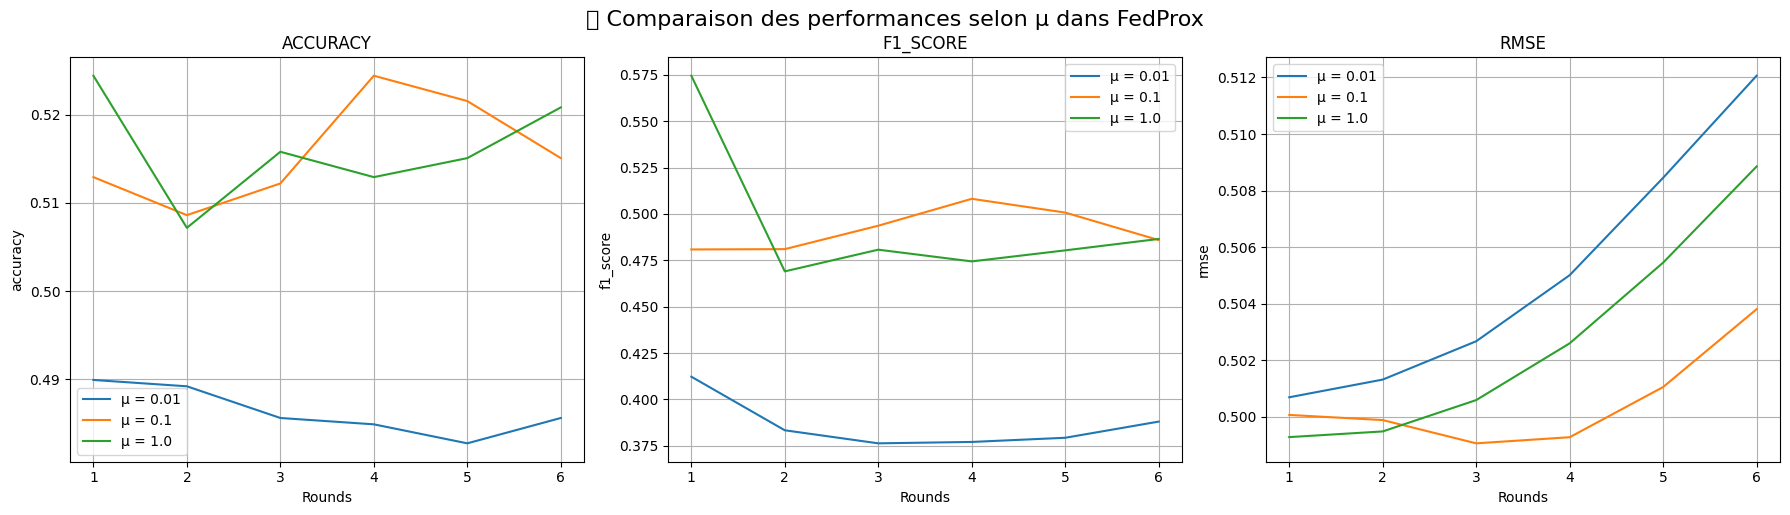

In [4]:
# --- Résumé des résultats finaux sur le jeu de test ---
print("\n📊 Résultats finaux sur le test set :")
for mu in mu_values:
    res = results_by_mu[mu]["test_final"]
    print(f"μ = {mu:<4} — Accuracy = {res['accuracy']:.4f}, F1 = {res['f1_score']:.4f}, RMSE = {res['rmse']:.4f}")

# --- Tracer les courbes d'évolution des métriques ---
import matplotlib.pyplot as plt

metrics_to_plot = ["accuracy", "f1_score", "rmse"]
plt.figure(figsize=(18, 5))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, len(metrics_to_plot), i)
    for mu in mu_values:
        rounds = range(1, len(results_by_mu[mu][metric]) + 1)
        plt.plot(rounds, results_by_mu[mu][metric], label=f"μ = {mu}")
    plt.title(metric.upper())
    plt.xlabel("Rounds")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📈 Comparaison des performances selon μ dans FedProx", fontsize=16, y=1.02)
plt.show()
